# **Modelling**

## **Step1.** Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle

In [3]:
#flights table
data = pd.read_csv('/Users/Prashanta/Desktop/airplane_data/flights_table(50,000_points).csv',delimiter=';')
data = data.iloc[: , 1:]

#create two samples of 10,000 points each
sample1 = data.sample(n=10000, random_state=0)
sample2 = data.sample(n=10000, random_state=1)

#Adding date time features and state
sample1['month'] = pd.DatetimeIndex(sample1['fl_date']).month
sample2['month'] = pd.DatetimeIndex(sample2['fl_date']).month
sample1['year'] = pd.DatetimeIndex(sample1['fl_date']).year
sample2['year'] = pd.DatetimeIndex(sample2['fl_date']).year
sample1['origin_city_state'] = sample1['origin_city_name'].transform(lambda x: str(x).split(',')[1])
sample2['origin_city_state'] = sample2['origin_city_name'].transform(lambda x: str(x).split(',')[1])
sample1['depart_hour'] = sample1['dep_time'].round(-2)
sample2['depart_hour'] = sample2['dep_time'].round(-2)

In [4]:
display(data.head(3))
display(data.shape)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2019-12-30,WN,WN,WN,775,WN,N255WN,775,13495,MSY,...,674.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-04-08,AS,AS,AS,352,AS,N464AS,352,14747,SEA,...,672.0,0.0,0.0,25.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2018-11-21,DL,DL,DL,1312,DL,N912DL,1312,10994,CHS,...,259.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(50000, 42)

## **Step2.** Create BaseModel using Linear Regression

In [5]:
#create test model df
test_model_1 = sample1[['month','origin_city_state','depart_hour','arr_delay']]

# Droping nan value rows
test_model_1.dropna(inplace=True)

# Encode Cateogircal Values 
# Change dtype of variable to category then encode using cat.codes
test_model_1['origin_city_state'] = test_model_1['origin_city_state'].astype('category')
test_model_1['origin_city_state'] = test_model_1['origin_city_state'].cat.codes

#Assign train and target variables
X = test_model_1[['month','origin_city_state','depart_hour']]
y = test_model_1['arr_delay']

<ipython-input-5-ac5d82c39b9a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_model_1.dropna(inplace=True)
<ipython-input-5-ac5d82c39b9a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_model_1['origin_city_state'] = test_model_1['origin_city_state'].astype('category')
<ipython-input-5-ac5d82c39b9a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [6]:
# split X and y into training and testing sets 
import sklearn.model_selection as model_selection

X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=123)

# import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#initialize and fit training dataset
Linear_Regressor = LinearRegression()
Linear_Regressor.fit(X_train, y_train)

#make prediction 
y_pred = Linear_Regressor.predict(X_test)

#prints the coefficients used for each attribute
print('variables', list(X.columns))
print('coefficients:', Linear_Regressor.coef_)
print()

#prints the R2 score for your test dataset
print('R2 Score for train data:', round(Linear_Regressor.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

variables ['month', 'origin_city_state', 'depart_hour']
coefficients: [-0.07959701  0.04777177  0.01045926]

R2 Score for train data: 0.012
R2 Score2 for test data: 0.015
MAE Score for test data:  23.62


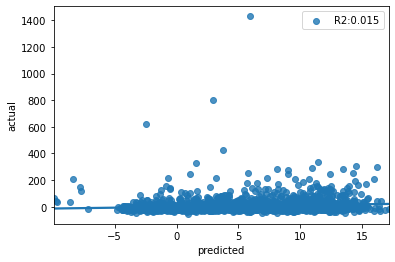

In [7]:
df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)

## **Step3.** Optimize model with better features and cleaner dataset

In [2]:
# load dataset (50,000 datapoints)
data = pd.read_csv('/Users/Prashanta/Desktop/airplane_data/flights_table(50,000_points).csv',delimiter=';')
data = data.iloc[: , 1:]

In [3]:
# drop all cancelled and diverted flights
filter1 = (data['cancelled']!=1) & (data['diverted']!=1)
data = data[filter1]

# drop outliers
data = data[(data['arr_delay']<50) & (data['arr_delay']>-50)]
data = data[(data['dep_delay']<50) & (data['dep_delay']>-50)]

#Adding date time features and state
data['month'] = pd.DatetimeIndex(data['fl_date']).month
data['year'] = pd.DatetimeIndex(data['fl_date']).year
data['day'] = pd.DatetimeIndex(data['fl_date']).day
data['origin_city_state'] = data['origin_city_name'].transform(lambda x: str(x).split(',')[1])
data['origin_city'] = data['origin_city_name'].transform(lambda x: str(x).split(',')[0])
data['dest_city_state'] = data['dest_city_name'].transform(lambda x: str(x).split(',')[1])
data['dest_city'] = data['dest_city_name'].transform(lambda x: str(x).split(',')[0])
data['depart_hour'] = data['dep_time'].round(-2)

# Add key features
data['Route'] = data['origin_city'] + ' to ' + data['dest_city']

data['dep_delay_route'] = data[['dep_delay','Route']].groupby(by='Route').transform(lambda x: x.mean())
data['arr_delay_route'] = data[['arr_delay','Route']].groupby(by='Route').transform(lambda x: x.mean())
data['taxi_out_route'] = data[['taxi_out','Route']].groupby(by='Route').transform(lambda x: x.mean())
data['taxi_in_route'] = data[['taxi_in','Route']].groupby(by='Route').transform(lambda x: x.mean())

data['dep_delay_city'] = data[['dep_delay','origin_city']].groupby(by='origin_city').transform(lambda x: x.mean())
data['arr_delay_city'] = data[['arr_delay','origin_city']].groupby(by='origin_city').transform(lambda x: x.mean())
data['taxi_out_city'] = data[['taxi_out','origin_city']].groupby(by='origin_city').transform(lambda x: x.mean())
data['taxi_in_city'] = data[['taxi_in','origin_city']].groupby(by='origin_city').transform(lambda x: x.mean())

data['dep_delay_month'] = data[['dep_delay','month']].groupby(by='month').transform(lambda x: x.mean())
data['arr_delay_month'] = data[['arr_delay','month']].groupby(by='month').transform(lambda x: x.mean())
data['taxi_out_month'] = data[['taxi_out','month']].groupby(by='month').transform(lambda x: x.mean())
data['taxi_in_month'] = data[['taxi_in','month']].groupby(by='month').transform(lambda x: x.mean())


#drop columns
data = data[['month','day','year','origin_city','origin_city_state','dest_city','dest_city_state','Route','distance','air_time','depart_hour','dep_delay_route','arr_delay_route','taxi_out_route','taxi_in_route','dep_delay_city','arr_delay_city','taxi_out_city','taxi_in_city','dep_delay_month','arr_delay_month','taxi_out_month','taxi_in_month','arr_delay']]

In [4]:
# missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

display(missing_data.head(20))
display(data.shape)

,Total,Percent
air_time,24,0.000538
arr_delay,0,0.000000
taxi_in_month,0,0.000000
day,0,0.000000
year,0,0.000000
origin_city,0,0.000000
origin_city_state,0,0.000000
dest_city,0,0.000000
dest_city_state,0,0.000000
Route,0,0.000000


(44575, 24)

In [5]:
#drop null values
data = data.dropna()
display(data.shape)

(44551, 24)

In [6]:
data.drop_duplicates()
display(data.shape)

(44551, 24)

In [7]:
display(data.head())
display(data.shape)

,month,day,year,origin_city,origin_city_state,dest_city,dest_city_state,Route,distance,air_time,...,taxi_in_route,dep_delay_city,arr_delay_city,taxi_out_city,taxi_in_city,dep_delay_month,arr_delay_month,taxi_out_month,taxi_in_month,arr_delay
0,12,30,2019,New Orleans,LA,Fort Lauderdale,FL,New Orleans to Fort Lauderdale,674.0,84.0,...,8.444444,1.710611,-4.176849,11.800643,8.057878,0.892546,-5.488575,17.429543,7.718988,-3.0
1,4,8,2018,Seattle,WA,Oakland,CA,Seattle to Oakland,672.0,98.0,...,6.208333,1.014692,-4.634527,19.509642,6.965106,-0.054939,-5.735341,16.802538,7.431139,25.0
2,11,21,2018,Charleston,SC,Atlanta,GA,Charleston to Atlanta,259.0,46.0,...,10.238095,-1.163522,-7.421384,14.861635,8.779874,0.093850,-5.732620,16.940107,7.404545,-13.0
3,12,19,2019,Fort Lauderdale,FL,Pittsburgh,PA,Fort Lauderdale to Pittsburgh,994.0,128.0,...,5.333333,1.163701,-4.740214,17.135231,7.814947,0.892546,-5.488575,17.429543,7.718988,-16.0
4,9,21,2019,Roanoke,VA,Chicago,IL,Roanoke to Chicago,530.0,82.0,...,10.666667,1.934783,-4.913043,18.152174,8.673913,-0.826569,-6.520833,16.681560,7.540753,-36.0


(44551, 24)

In [8]:
# Encode Cateogircal Values 
# Change dtype of variable to category then encode using cat.codes
data['origin_city_state'] = data['origin_city_state'].astype('category')
data['origin_city'] = data['origin_city'].astype('category')
data['dest_city_state'] = data['dest_city_state'].astype('category')
data['dest_city'] = data['dest_city'].astype('category')
data['Route'] = data['Route'].astype('category')

data['origin_city_state'] = data['origin_city_state'].cat.codes
data['origin_city'] = data['origin_city'].cat.codes
data['dest_city_state'] = data['dest_city_state'].cat.codes
data['dest_city'] = data['dest_city'].cat.codes
data['Route'] = data['Route'].cat.codes

In [9]:
display(data.head())
display(data.shape)

,month,day,year,origin_city,origin_city_state,dest_city,dest_city_state,Route,distance,air_time,...,taxi_in_route,dep_delay_city,arr_delay_city,taxi_out_city,taxi_in_city,dep_delay_month,arr_delay_month,taxi_out_month,taxi_in_month,arr_delay
0,12,30,2019,220,17,105,8,2987,674.0,84.0,...,8.444444,1.710611,-4.176849,11.800643,8.057878,0.892546,-5.488575,17.429543,7.718988,-3.0
1,4,8,2018,296,49,233,4,4370,672.0,98.0,...,6.208333,1.014692,-4.634527,19.509642,6.965106,-0.054939,-5.735341,16.802538,7.431139,25.0
2,11,21,2018,52,40,17,9,604,259.0,46.0,...,10.238095,-1.163522,-7.421384,14.861635,8.779874,0.093850,-5.732620,16.940107,7.404545,-13.0
3,12,19,2019,103,8,249,37,1730,994.0,128.0,...,5.333333,1.163701,-4.740214,17.135231,7.814947,0.892546,-5.488575,17.429543,7.718988,-16.0
4,9,21,2019,267,46,61,13,3848,530.0,82.0,...,10.666667,1.934783,-4.913043,18.152174,8.673913,-0.826569,-6.520833,16.681560,7.540753,-36.0


(44551, 24)

variables ['month', 'day', 'year', 'origin_city', 'origin_city_state', 'dest_city', 'dest_city_state', 'Route', 'distance', 'air_time', 'depart_hour', 'dep_delay_route', 'arr_delay_route', 'taxi_out_route', 'taxi_in_route', 'dep_delay_city', 'arr_delay_city', 'taxi_out_city', 'taxi_in_city', 'dep_delay_month', 'arr_delay_month', 'taxi_out_month', 'taxi_in_month']
coefficients: [-3.20954591e-02  3.50808909e-04 -3.32329141e-01 -9.54766740e-03
 -1.31835684e-02 -4.34790556e-03  4.40292522e-03  8.79979738e-04
 -3.51500541e-02  2.99743638e-01  3.30375563e-03  1.12509210e-01
  8.53893543e-01  1.07917652e-01 -6.29522355e-02 -3.28976879e-01
  3.36282118e-01 -2.93094915e-01 -3.12688828e-01 -6.32303586e-01
  1.17583505e+00 -2.40475550e-01  1.98725756e+00]

R2 Score for train data: 0.195
R2 Score2 for test data: 0.196
MAE Score for test data:  10.66


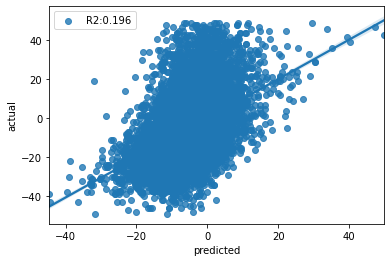

In [10]:
#Assign train and target variables
X = data[['month','day','year','origin_city','origin_city_state','dest_city','dest_city_state','Route','distance','air_time','depart_hour','dep_delay_route','arr_delay_route','taxi_out_route','taxi_in_route','dep_delay_city','arr_delay_city','taxi_out_city','taxi_in_city','dep_delay_month','arr_delay_month','taxi_out_month','taxi_in_month']]
y = data['arr_delay']

# split X and y into training and testing sets 
import sklearn.model_selection as model_selection

X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=123)

# import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#initialize and fit training dataset
model = LinearRegression()
model.fit(X_train, y_train)

#save the model
#filename = 'Linear_Regression_Model.sav'
#pickle.dump(model,open(filename, 'wb'))

#make prediction 
y_pred = model.predict(X_test)

#prints the coefficients used for each attribute
print('variables', list(X.columns))
print('coefficients:', model.coef_)
print()

#prints the R2 score for your test dataset
print('R2 Score for train data:', round(model.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

## **Step3.** Try other models

In [17]:
display(data.head(3))
display(data.shape)

#Assign train and target variables
X = data[['month','day','year','origin_city','origin_city_state','dest_city','dest_city_state','Route','distance','air_time','depart_hour','dep_delay_route','arr_delay_route','taxi_out_route','taxi_in_route','dep_delay_city','arr_delay_city','taxi_out_city','taxi_in_city','dep_delay_month','arr_delay_month','taxi_out_month','taxi_in_month']]
y = data['arr_delay']

# split X and y into training and testing sets 
import sklearn.model_selection as model_selection

X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,train_size=0.75,test_size=0.25,random_state=123)

,month,day,year,origin_city,origin_city_state,dest_city,dest_city_state,Route,distance,air_time,...,taxi_in_route,dep_delay_city,arr_delay_city,taxi_out_city,taxi_in_city,dep_delay_month,arr_delay_month,taxi_out_month,taxi_in_month,arr_delay
0,12,30,2019,220,17,105,8,2987,674.0,84.0,...,8.444444,1.710611,-4.176849,11.800643,8.057878,0.892546,-5.488575,17.429543,7.718988,-3.0
1,4,8,2018,296,49,233,4,4370,672.0,98.0,...,6.208333,1.014692,-4.634527,19.509642,6.965106,-0.054939,-5.735341,16.802538,7.431139,25.0
2,11,21,2018,52,40,17,9,604,259.0,46.0,...,10.238095,-1.163522,-7.421384,14.861635,8.779874,0.093850,-5.732620,16.940107,7.404545,-13.0


(44551, 24)

In [ ]:
### **Step3a.** Random Forest

In [17]:
# import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [21]:
#Create a Gaussian Classifier
model = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
model.fit(X_train,y_train)

#save the model
filename = 'Random_Forest_Model.sav'
pickle.dump(model,open(filename, 'wb'))

y_pred = model.predict(X_test)

R2 Score for train data: 1.0
R2 Score2 for test data: -0.63
MAE Score for test data:  14.99


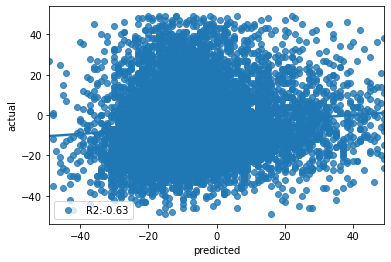

In [24]:
#prints the R2 score for your test dataset
print('R2 Score for train data:', round(model.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

### **Step3b.** Random Forest Grid Search

In [43]:
#define hyperparameters we want to tune
param_grid = {
    'n_estimators' : [5,10,15,100,150],
    'criterion' : ['gini,', 'entropy'],
    'max_depth' : [5,8,10,12,15]
}

#instantiate GridSearchCV, fit model, and make prediction
model = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv = 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

df = pd.DataFrame(model.cv_results_)

/Users/Prashanta/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/Prashanta/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Prashanta/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Prashanta/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/Users/Prashanta/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1041, in __call__
   

In [44]:
display(model.best_params_)
display(model.best_score_)

df.sort_values('rank_test_score', ascending = True).head(3)

{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 150}

0.03408853487047127

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
29,8.108485,0.215984,0.791526,0.079942,entropy,5,150,"{'criterion': 'entropy', 'max_depth': 5, 'n_es...",0.034565,0.035613,0.031872,0.036965,0.031428,0.034089,0.002136,1
28,5.556024,0.447835,0.522679,0.103270,entropy,5,100,"{'criterion': 'entropy', 'max_depth': 5, 'n_es...",0.036211,0.033967,0.031573,0.034421,0.033373,0.033909,0.001504,2
26,0.821777,0.264403,0.104671,0.029499,entropy,5,10,"{'criterion': 'entropy', 'max_depth': 5, 'n_es...",0.032171,0.031872,0.032022,0.036366,0.032775,0.033041,0.001691,3


### **Step4a.** Poly Regression

In [71]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [72]:
#Create a Gaussian Classifier
model = make_pipeline(PolynomialFeatures(2),LinearRegression())

#Train the model using the training sets y_pred=clf.predict(X_test)
model.fit(X_train,y_train)

#save the model
filename = 'Poly_regression.sav'
pickle.dump(model,open(filename, 'wb'))

y_pred = model.predict(X_test)

In [75]:
type(y_pred[1])

numpy.float64

R2 Score for train data: 0.225
R2 Score2 for test data: 0.222
MAE Score for test data:  10.49


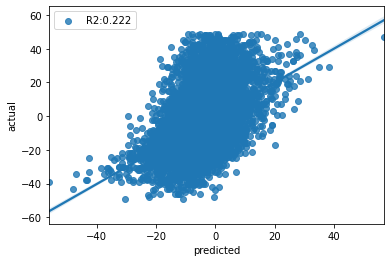

In [20]:
#prints the R2 score for your test dataset
print('R2 Score for train data:', round(model.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

### **Step4b.** Poly Regression Grid Search

In [21]:
#Create a Gaussian Classifier

x = [1,2,3]
scores = []

for x in x:
    model = make_pipeline(PolynomialFeatures(x),LinearRegression())
    #Train the model using the training sets y_pred=clf.predict(X_test)
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    
    scores.append(round(r2_score(y_test,y_pred),3))

#save the model
#filename = 'Poly_regression.sav'
#pickle.dump(model,open(filename, 'wb'))

In [54]:
print('R2 Scores by parameter:')
print('Feature 1 = ', scores[0])
print('Feature 2 = ', scores[1])
print('Feature 3 = ', scores[2])

R2 Scores by parameter:
Feature 1 =  0.196
Feature 2 =  0.222
Feature 3 =  0.172


### **Step5a.** Naive Bayes

In [84]:
from sklearn.naive_bayes import GaussianNB 
from sklearn import metrics

model = GaussianNB()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

In [85]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred, average='weighted'))
print("Recall:", metrics.recall_score(y_test, y_pred, average='weighted'))

Accuracy: 0.02882025498294128
Precision: 0.02543845672794138
Recall: 0.02882025498294128


/Users/Prashanta/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


R2 Score for train data: 0.036
R2 Score2 for test data: -0.697
MAE Score for test data:  14.73


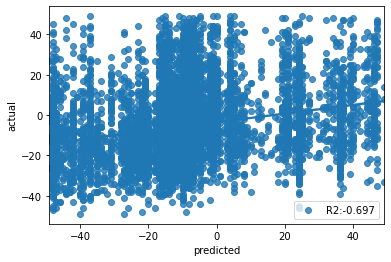

In [86]:
#prints the R2 score for your test dataset
print('R2 Score for train data:', round(model.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

### **Step6a.** SGDRegressor

In [90]:
from sklearn.linear_model import SGDRegressor

model = SGDRegressor()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

R2 Score for train data: -1.7270573694405094e+27
R2 Score2 for test data: -1.7078601571329052e+27
MAE Score for test data:  526238243103679.44


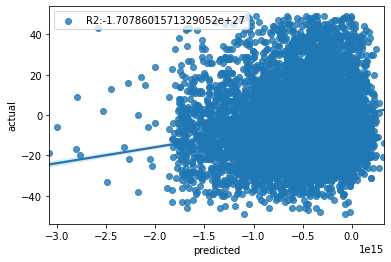

In [91]:
#prints the R2 score for your test dataset
print('R2 Score for train data:', round(model.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

### **Step6b.** SGDRegressor Grid Search

In [93]:
#define hyperparameters we want to tune
param_grid = {
    'loss' : ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty' : ['l2', 'l1', 'elasticnet']
}

from sklearn.model_selection import GridSearchCV

#instantiate GridSearchCV, fit model, and make prediction
model = GridSearchCV(SGDRegressor(), param_grid = param_grid, cv = 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

df = pd.DataFrame(model.cv_results_)

/Users/Prashanta/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/Prashanta/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/Prashanta/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/Prashanta/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1220:

In [94]:
display(model.best_params_)
display(model.best_score_)

df.sort_values('rank_test_score', ascending = True).head(3)

{'loss': 'huber', 'penalty': 'l1'}

-49.29133187164935

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.688831,0.102267,0.003348,0.000224,huber,l1,"{'loss': 'huber', 'penalty': 'l1'}",-0.116050,-0.394104,-127.297427,-8.806414,-109.842664,-49.291332,56.920278,1
3,3.728264,0.545099,0.003578,0.000959,huber,l2,"{'loss': 'huber', 'penalty': 'l2'}",-247.411209,-69.939567,-9.538978,-2.642132,-10.655818,-68.037541,92.919141,2
5,1.499822,0.187986,0.003158,0.000066,huber,elasticnet,"{'loss': 'huber', 'penalty': 'elasticnet'}",-51.067638,-7.628113,-53.011055,-27.047768,-383.349792,-104.420873,140.460895,3


### **Step7a.** SVR

In [12]:
from sklearn.svm import SVR

model = SVR()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

R2 Score for train data: -0.001
R2 Score2 for test data: -0.0
MAE Score for test data:  11.7


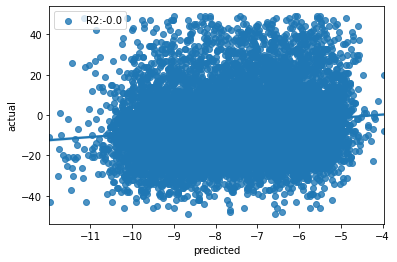

In [16]:
#prints the R2 score for your test dataset
print('R2 Score for train data:', round(model.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

### **Step7b.** SVR Grid Search

In [ ]:
#define hyperparameters we want to tune
param_grid = {
    'C' : [1,10,20],
    'kernel' : ['rbf','linear','sigmoid'],
    'gamma' : ['scale', 'auto'],
}

from sklearn.model_selection import GridSearchCV

#instantiate GridSearchCV, fit model, and make prediction
model = GridSearchCV(SVR(), param_grid = param_grid, cv = 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

df = pd.DataFrame(model.cv_results_)

In [ ]:
display(model.best_params_)
display(model.best_score_)

df.sort_values('rank_test_score', ascending = True).head(3)

### **Step8a.** AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

In [ ]:
#prints the R2 score for your test dataset
print('R2 Score for train data:', round(model.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

### **Step8b.** AdaBoost Classifier Grid Search

In [ ]:
#define hyperparameters we want to tune
param_grid = {
    'n_estimators' : [50,100,150],
    'algorithm' : ['SAMME','SAMME.R'],
    'gamma' : ['scale', 'auto'],
}

from sklearn.model_selection import GridSearchCV

#instantiate GridSearchCV, fit model, and make prediction
model = GridSearchCV(SVR(), param_grid = param_grid, cv = 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

df = pd.DataFrame(model.cv_results_)

In [ ]:
display(model.best_params_)
display(model.best_score_)

df.sort_values('rank_test_score', ascending = True).head(3)

### **Step9a.** ElasticNet Classifier

In [ ]:
from sklearn.linear_model import ElasticNet

model = ElasticNet()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

In [ ]:
#prints the R2 score for your test dataset
print('R2 Score for train data:', round(model.score(X_train,y_train),3))
print('R2 Score2 for test data:', round(r2_score(y_test,y_pred),3))
print('MAE Score for test data: ', round(mean_absolute_error(y_test,y_pred),2))

df = pd.DataFrame(
        {
            'actual':y_test,
            'predicted':y_pred
        }
)
df

sns.regplot(x='predicted',y='actual',data=df,label='R2:'+ str(round(r2_score(y_test,y_pred),3)))
plt.legend(loc=0)
plt.show()

### **Step9b.** ElasticNet Classifier Grid Search

In [ ]:
#define hyperparameters we want to tune
param_grid = {
    'n_estimators' : [50,100,150],
    'algorithm' : ['SAMME','SAMME.R'],
    'gamma' : ['scale', 'auto'],
}

from sklearn.model_selection import GridSearchCV

#instantiate GridSearchCV, fit model, and make prediction
model = GridSearchCV(ElasticNet(), param_grid = param_grid, cv = 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

df = pd.DataFrame(model.cv_results_)